In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.cluster import KMeans

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    silhouette_score,
    auc
)


In [2]:
url = "https://raw.githubusercontent.com/mor2800/Mor-Heymann/main/data/Selected_Online_Sport_Wagering_Data%20(1).csv"
df = pd.read_csv(url)

print(df.head())
print("Rows, Columns:", df.shape)

                              Licensee Fiscal Year            Month Ending  \
0  MPI Master Wagering License CT, LLC     2025/26  09/30/2025 12:00:00 AM   
1                 Mohegan Digital, LLC     2025/26  09/30/2025 12:00:00 AM   
2                      CT Lottery Corp     2025/26  09/30/2025 12:00:00 AM   
3  MPI Master Wagering License CT, LLC     2025/26  08/31/2025 12:00:00 AM   
4                 Mohegan Digital, LLC     2025/26  08/31/2025 12:00:00 AM   

     Wagers  Patron Winnings  Cancelled Wagers  Monthly Resettlements (3)  \
0  88988374         82127396            170944                    -349288   
1  87210720         77897224            346605                       5396   
2  45365455         42115726            103347                      89536   
3  55467015         49222929            261060                      49799   
4  52267780         45029837            232407                      13302   

   Online Sports Wagering Win/(Loss)  Federal Excise Tax (4)  \
0   

In [3]:
print("Rows, Columns:", df.shape)

print("\nColumns:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values (%):")
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print(missing_pct)

Rows, Columns: (144, 15)

Columns:
['Licensee', 'Fiscal Year', 'Month Ending', 'Wagers', 'Patron Winnings', 'Cancelled Wagers', 'Monthly Resettlements (3)', 'Online Sports Wagering Win/(Loss)', 'Federal Excise Tax (4)', 'Unadjusted Monthly Gaming Revenue', 'Promotional Coupons or Credits Wagered (5)', 'Promotional Deduction (6)', 'Total Gross Gaming Revenue', 'Payment (7)', 'Notes']

Data types:
Licensee                                      object
Fiscal Year                                   object
Month Ending                                  object
Wagers                                         int64
Patron Winnings                                int64
Cancelled Wagers                               int64
Monthly Resettlements (3)                      int64
Online Sports Wagering Win/(Loss)              int64
Federal Excise Tax (4)                         int64
Unadjusted Monthly Gaming Revenue              int64
Promotional Coupons or Credits Wagered (5)     int64
Promotional Deduct

In [4]:
# 1) Clean whitespace
df["Month Ending"] = df["Month Ending"].astype(str).str.strip()

# 2) Convert to datetime
df["Month Ending"] = pd.to_datetime(df["Month Ending"], errors="coerce")

# 3) Check invalid dates
print("Invalid dates:", df["Month Ending"].isna().sum())

# 4) Sort by date
df = df.sort_values("Month Ending")

df[["Month Ending"]].head(10)

Invalid dates: 0


/var/folders/g5/xwsvl7vn15d42_q16xxg893r0000gn/T/ipykernel_43521/2969864445.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Month Ending"] = pd.to_datetime(df["Month Ending"], errors="coerce")


,Month Ending
143,2021-10-31
142,2021-10-31
141,2021-10-31
138,2021-11-30
140,2021-11-30
139,2021-11-30
137,2021-12-31
136,2021-12-31
135,2021-12-31
134,2022-01-31


In [5]:
df["Month Ending"] = pd.to_datetime(df["Month Ending"], errors="coerce")
print(df["Month Ending"].dtype)

datetime64[ns]


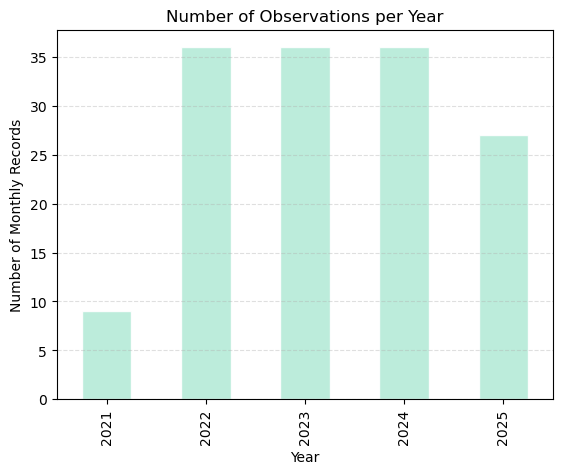

In [6]:
years = df["Month Ending"].dt.year

plt.figure()
years.value_counts().sort_index().plot(
    kind="bar",
    color="#B5EAD7",      # ירוק פסטלי
    edgecolor="white",
    alpha=0.9
)

plt.title("Number of Observations per Year")
plt.xlabel("Year")
plt.ylabel("Number of Monthly Records")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


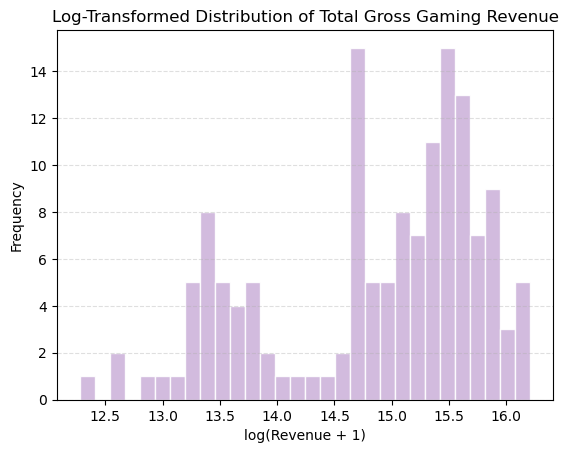

In [7]:
plt.figure()

plt.hist(
    np.log1p(df["Total Gross Gaming Revenue"]),
    bins=30,
   color="#CDB4DB"
,      # פסטל כחול
    edgecolor="white",
    alpha=0.9
)

plt.title("Log-Transformed Distribution of Total Gross Gaming Revenue")
plt.xlabel("log(Revenue + 1)")
plt.ylabel("Frequency")

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()


In [8]:
#  Create binary target variable
target_col = "Total Gross Gaming Revenue"

# Calculate median
median_revenue = df[target_col].median()

# Create binary target
df["target_high_revenue"] = (df[target_col] >= median_revenue).astype(int)

print("Median revenue:", median_revenue)
print("\nTarget value counts:")
print(df["target_high_revenue"].value_counts())

print("\nTarget distribution (%):")
print(df["target_high_revenue"].value_counts(normalize=True).round(3))


Median revenue: 3760814.5

Target value counts:
target_high_revenue
0    72
1    72
Name: count, dtype: int64

Target distribution (%):
target_high_revenue
0    0.5
1    0.5
Name: proportion, dtype: float64


In [9]:
print(df["target_high_revenue"].value_counts(normalize=True))

target_high_revenue
0    0.5
1    0.5
Name: proportion, dtype: float64


In [10]:
df["month"] = df["Month Ending"].dt.month
df["year"] = df["Month Ending"].dt.year

df[["Month Ending", "month", "year"]].head(10)


,Month Ending,month,year
143,2021-10-31,10,2021
142,2021-10-31,10,2021
141,2021-10-31,10,2021
138,2021-11-30,11,2021
140,2021-11-30,11,2021
139,2021-11-30,11,2021
137,2021-12-31,12,2021
136,2021-12-31,12,2021
135,2021-12-31,12,2021
134,2022-01-31,1,2022


In [11]:
y = df["target_high_revenue"]

drop_cols = [
    "Total Gross Gaming Revenue",
    "target_high_revenue",
    "Month Ending",
    "Notes"
]

X = df.drop(columns=drop_cols)

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()


X shape: (144, 14)
y shape: (144,)


,Licensee,Fiscal Year,Wagers,Patron Winnings,Cancelled Wagers,Monthly Resettlements (3),Online Sports Wagering Win/(Loss),Federal Excise Tax (4),Unadjusted Monthly Gaming Revenue,Promotional Coupons or Credits Wagered (5),Promotional Deduction (6),Payment (7),month,year
143,CT Lottery Corp,2021/22,3246536,2901339,41418,10047,293732,8013,285720,404431,71430,29465,10,2021
142,"Mohegan Digital, LLC",2021/22,27082842,26047082,102765,58834,874160,61453,812707,2398934,203177,83810,10,2021
141,"MPI Master Wagering License CT, LLC",2021/22,23770250,20117086,43488,-4121,3613797,53427,3560370,2119449,890092,367163,10,2021
138,"MPI Master Wagering License CT, LLC",2021/22,60031024,52870165,164994,28431,6967434,143877,6823557,2045623,1705889,703679,11,2021
140,CT Lottery Corp,2021/22,8518887,7660972,99459,-3267,761722,21279,740443,405253,185111,76358,11,2021


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:")
print(y_train.value_counts())
print("y_test distribution:")
print(y_test.value_counts())


X_train shape: (115, 14)
X_test shape: (29, 14)
y_train distribution:
target_high_revenue
1    58
0    57
Name: count, dtype: int64
y_test distribution:
target_high_revenue
0    15
1    14
Name: count, dtype: int64


In [13]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:")
print(numeric_features)

print("\nCategorical features:")
print(categorical_features)


Numeric features:
['Wagers', 'Patron Winnings', 'Cancelled Wagers', 'Monthly Resettlements (3)', 'Online Sports Wagering Win/(Loss)', 'Federal Excise Tax (4)', 'Unadjusted Monthly Gaming Revenue', 'Promotional Coupons or Credits Wagered (5)', 'Promotional Deduction (6)', 'Payment (7)']

Categorical features:
['Licensee', 'Fiscal Year']


In [14]:
# Numeric pipeline
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# Categorical pipeline
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [15]:
# Fit on training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)


Processed X_train shape: (115, 18)
Processed X_test shape: (29, 18)


In [16]:
# Build full pipeline: preprocessing + model
logreg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ]
)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on test set
y_pred = logreg_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [17]:
# Build pipeline with Decision Tree
dt_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(
            max_depth=5,
            random_state=42
        ))
    ]
)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [18]:
# Random Forest pipeline
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=100,
            random_state=42
        ))
    ]
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [19]:
#  Time-based split (train = earlier months, test = later months)

# make sure df is sorted by time
df = df.sort_values("Month Ending").reset_index(drop=True)

# rebuild X, y (same as before)
y_time = df["target_high_revenue"]
X_time = df.drop(columns=[
    "Total Gross Gaming Revenue",
    "target_high_revenue",
    "Month Ending",
    "Notes"
])

# split index: last 20% as test
split_idx = int(len(df) * 0.8)

X_train_t, X_test_t = X_time.iloc[:split_idx], X_time.iloc[split_idx:]
y_train_t, y_test_t = y_time.iloc[:split_idx], y_time.iloc[split_idx:]

print("Train period:", df["Month Ending"].iloc[0], "->", df["Month Ending"].iloc[split_idx-1])
print("Test period :", df["Month Ending"].iloc[split_idx], "->", df["Month Ending"].iloc[-1])

print("\nTrain distribution:")
print(y_train_t.value_counts())
print("\nTest distribution:")
print(y_test_t.value_counts())


Train period: 2021-10-31 00:00:00 -> 2024-12-31 00:00:00
Test period : 2024-12-31 00:00:00 -> 2025-09-30 00:00:00

Train distribution:
target_high_revenue
0    62
1    53
Name: count, dtype: int64

Test distribution:
target_high_revenue
1    19
0    10
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

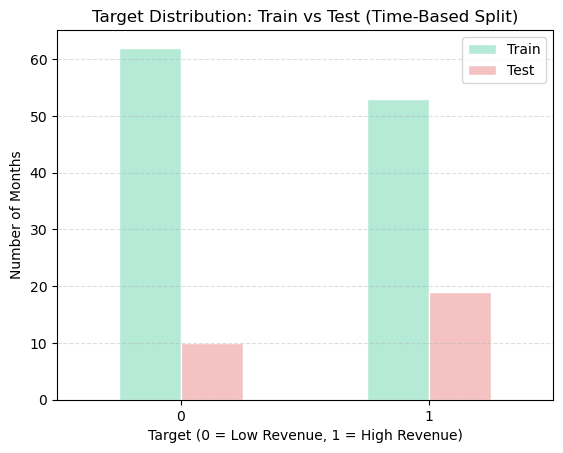

In [20]:
train_counts = y_train_t.value_counts().sort_index()
test_counts = y_test_t.value_counts().sort_index()

dist_df = pd.DataFrame({
    "Train": train_counts,
    "Test": test_counts
}).fillna(0)

plt.figure()
dist_df.plot(
    kind="bar",
    color=["#B5EAD7", "#F4C2C2"], 
    edgecolor="white"
)

plt.title("Target Distribution: Train vs Test (Time-Based Split)")
plt.xlabel("Target (0 = Low Revenue, 1 = High Revenue)")
plt.ylabel("Number of Months")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()


In [21]:

logreg_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ]
)

# Train on past data
logreg_time.fit(X_train_t, y_train_t)

# Predict future data
y_pred_time = logreg_time.predict(X_test_t)

print("Accuracy:", accuracy_score(y_test_t, y_pred_time))
print("\nClassification Report:\n")
print(classification_report(y_test_t, y_pred_time))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        19

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



<Figure size 640x480 with 0 Axes>

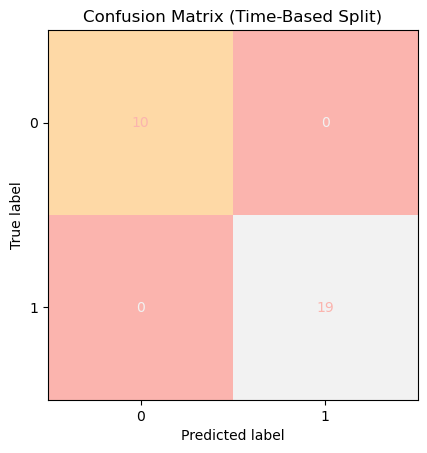

In [22]:
# Confusion Matrix for time-based split
cm = confusion_matrix(y_test_t, y_pred_time)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Pastel1", values_format="d", colorbar=False)

plt.title("Confusion Matrix (Time-Based Split)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


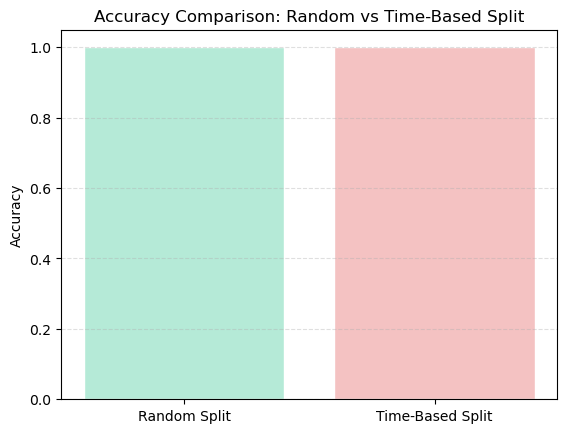

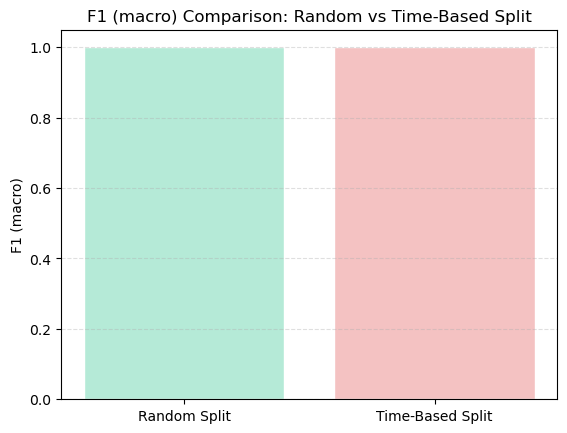

,Split,Accuracy,F1 (macro)
0,Random Split,1.0,1.0
1,Time-Based Split,1.0,1.0


In [23]:

# --- build X,y ONCE (same columns for both splits) ---
drop_cols = ["Total Gross Gaming Revenue", "target_high_revenue", "Month Ending", "Notes"]
X_all = df.drop(columns=drop_cols)
y_all = df["target_high_revenue"]

# --- 1) Random split ---
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

logreg_random = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_random.fit(X_train_r, y_train_r)
y_pred_random = logreg_random.predict(X_test_r)

# --- 2) Time-based split (same X_all, just by time index) ---
df_sorted = df.sort_values("Month Ending").reset_index(drop=True)
X_time = df_sorted.drop(columns=drop_cols)
y_time = df_sorted["target_high_revenue"]

split_idx = int(len(df_sorted) * 0.8)
X_train_t = X_time.iloc[:split_idx]
X_test_t  = X_time.iloc[split_idx:]
y_train_t = y_time.iloc[:split_idx]
y_test_t  = y_time.iloc[split_idx:]

logreg_time = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_time.fit(X_train_t, y_train_t)
y_pred_time = logreg_time.predict(X_test_t)

# --- Metrics table ---
results = pd.DataFrame({
    "Split": ["Random Split", "Time-Based Split"],
    "Accuracy": [
        accuracy_score(y_test_r, y_pred_random),
        accuracy_score(y_test_t, y_pred_time)
    ],
    "F1 (macro)": [
        f1_score(y_test_r, y_pred_random, average="macro"),
        f1_score(y_test_t, y_pred_time, average="macro")
    ]
})

# --- Plot Accuracy ---
plt.figure()
plt.bar(results["Split"], results["Accuracy"], color=["#B5EAD7", "#F4C2C2"], edgecolor="white")
plt.title("Accuracy Comparison: Random vs Time-Based Split")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

# --- Plot F1 ---
plt.figure()
plt.bar(results["Split"], results["F1 (macro)"], color=["#B5EAD7", "#F4C2C2"], edgecolor="white")
plt.title("F1 (macro) Comparison: Random vs Time-Based Split")
plt.ylabel("F1 (macro)")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

results


In [24]:

rf_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ))
    ]
)

rf_time.fit(X_train_t, y_train_t)
y_pred_rf_time = rf_time.predict(X_test_t)

print("Accuracy:", accuracy_score(y_test_t, y_pred_rf_time))
print("\nClassification Report:\n")
print(classification_report(y_test_t, y_pred_rf_time))


Accuracy: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        20

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



                                            feature  importance
9                                  num__Payment (7)    0.300771
6            num__Unadjusted Monthly Gaming Revenue    0.201743
4            num__Online Sports Wagering Win/(Loss)    0.161519
8                    num__Promotional Deduction (6)    0.100977
0                                       num__Wagers    0.076431
5                       num__Federal Excise Tax (4)    0.062139
1                              num__Patron Winnings    0.049516
13                         cat__Fiscal Year_2021/22    0.014006
7   num__Promotional Coupons or Credits Wagered (5)    0.013850
2                             num__Cancelled Wagers    0.008251
10                    cat__Licensee_CT Lottery Corp    0.006064
3                    num__Monthly Resettlements (3)    0.002526


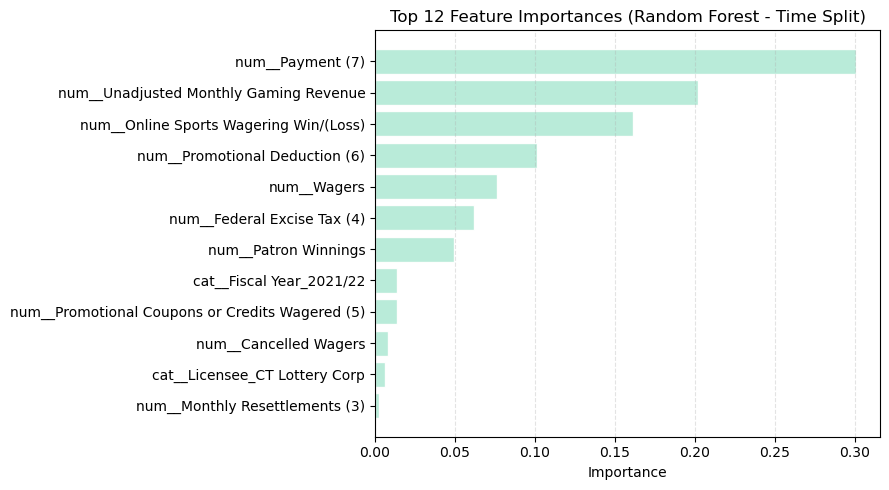

In [25]:
# --- 1) Extract fitted preprocessor + model from the pipeline ---
preproc = rf_time.named_steps["preprocessor"]
rf_clf  = rf_time.named_steps["classifier"]

# --- 2) Get feature names AFTER preprocessing (numeric + one-hot categorical) ---
feature_names = preproc.get_feature_names_out()

# --- 3) Build importance dataframe ---
importances = rf_clf.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# --- 4) Show top N ---
top_n = 12
fi_top = fi.head(top_n)

print(fi_top)

# --- 5) Plot (pastel) ---
plt.figure(figsize=(9, 5))
plt.barh(
    fi_top["feature"][::-1],
    fi_top["importance"][::-1],
    color="#B5EAD7",      # פסטל ירוק
    edgecolor="white",
    alpha=0.95
)

plt.title(f"Top {top_n} Feature Importances (Random Forest - Time Split)")
plt.xlabel("Importance")
plt.grid(axis="x", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


In [26]:

# Logistic Regression ROC-AUC (time split)
y_proba_log = logreg_time.predict_proba(X_test_t)[:, 1]
auc_log = roc_auc_score(y_test_t, y_proba_log)

# Random Forest ROC-AUC (time split)
y_proba_rf = rf_time.predict_proba(X_test_t)[:, 1]
auc_rf = roc_auc_score(y_test_t, y_proba_rf)

print("ROC-AUC (Logistic, time split):", round(auc_log, 4))
print("ROC-AUC (Random Forest, time split):", round(auc_rf, 4))


ROC-AUC (Logistic, time split): 1.0
ROC-AUC (Random Forest, time split): 1.0


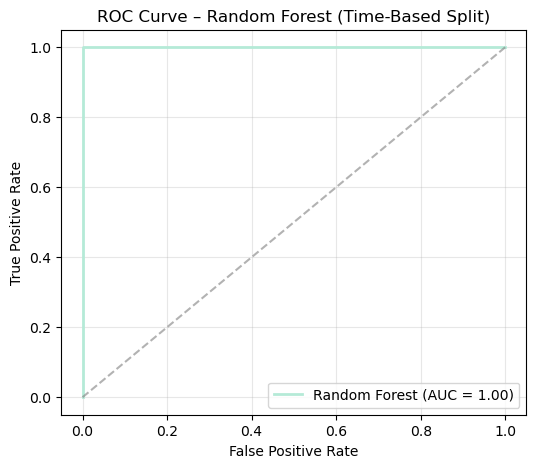

In [27]:
# חישוב הסתברויות
y_proba_rf = rf_time.predict_proba(X_test_t)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test_t, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr,
    tpr,
    label=f"Random Forest (AUC = {roc_auc:.2f})",
    color="#B5EAD7",   # ירוק פסטלי
    linewidth=2
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest (Time-Based Split)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [28]:

knn_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=5))
    ]
)

knn_time.fit(X_train_t, y_train_t)
y_pred_knn = knn_time.predict(X_test_t)

print("Accuracy (kNN, time split):", accuracy_score(y_test_t, y_pred_knn))
print("\nClassification Report (kNN):\n")
print(classification_report(y_test_t, y_pred_knn))


Accuracy (kNN, time split): 1.0

Classification Report (kNN):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        20

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [29]:

gb_time = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42))
    ]
)

gb_time.fit(X_train_t, y_train_t)
y_pred_gb = gb_time.predict(X_test_t)

print("Accuracy (Gradient Boosting, time split):", accuracy_score(y_test_t, y_pred_gb))
print("\nClassification Report (Gradient Boosting):\n")
print(classification_report(y_test_t, y_pred_gb))


Accuracy (Gradient Boosting, time split): 1.0

Classification Report (Gradient Boosting):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        20

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [30]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

# Cross-validation on TRAIN only (time-based train set)
cv_results_log = cross_validate(
    logreg_time, X_train_t, y_train_t, cv=cv, scoring=scoring
)

cv_results_rf = cross_validate(
    rf_time, X_train_t, y_train_t, cv=cv, scoring=scoring
)

def summarize_cv(name, res):
    print(f"\n{name} (5-Fold CV on TRAIN):")
    for k in scoring.keys():
        scores = res[f"test_{k}"]
        print(f"  {k}: mean={scores.mean():.3f}, std={scores.std():.3f}")

summarize_cv("Logistic Regression", cv_results_log)
summarize_cv("Random Forest", cv_results_rf)



Logistic Regression (5-Fold CV on TRAIN):
  accuracy: mean=0.965, std=0.017
  precision: mean=0.982, std=0.036
  recall: mean=0.944, std=0.046
  f1: mean=0.961, std=0.020
  roc_auc: mean=0.997, std=0.006

Random Forest (5-Fold CV on TRAIN):
  accuracy: mean=0.974, std=0.021
  precision: mean=0.965, std=0.043
  recall: mean=0.982, std=0.036
  f1: mean=0.972, std=0.023
  roc_auc: mean=0.997, std=0.006


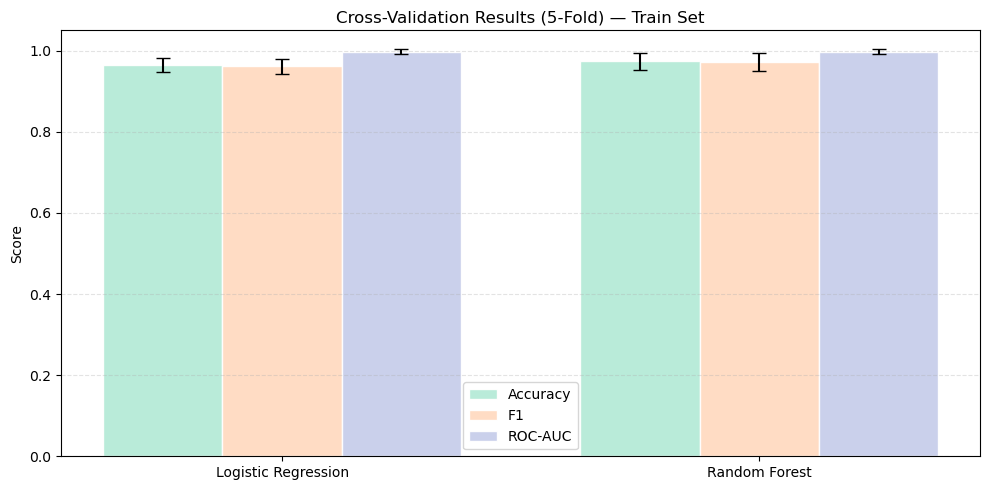

,Model,Accuracy_mean,Accuracy_std,F1_mean,F1_std,ROC_AUC_mean,ROC_AUC_std
0,Logistic Regression,0.965217,0.017391,0.960902,0.019645,0.99697,0.006061
1,Random Forest,0.973913,0.021300,0.972257,0.022703,0.99697,0.006061


In [31]:
# --- Build summary table from cross_validate outputs ---
def cv_to_row(name, res):
    return {
        "Model": name,
        "Accuracy_mean": res["test_accuracy"].mean(),
        "Accuracy_std":  res["test_accuracy"].std(),
        "F1_mean":       res["test_f1"].mean(),
        "F1_std":        res["test_f1"].std(),
        "ROC_AUC_mean":  res["test_roc_auc"].mean(),
        "ROC_AUC_std":   res["test_roc_auc"].std(),
    }

summary = pd.DataFrame([
    cv_to_row("Logistic Regression", cv_results_log),
    cv_to_row("Random Forest", cv_results_rf)
])

metrics = [
    ("Accuracy", "Accuracy_mean", "Accuracy_std", "#B5EAD7"), 
    ("F1",       "F1_mean",       "F1_std",       "#FFDAC1"),  
    ("ROC-AUC",  "ROC_AUC_mean",  "ROC_AUC_std",  "#C7CEEA"),  
]

x = np.arange(len(summary["Model"]))
bar_width = 0.25

plt.figure(figsize=(10, 5))

for i, (label, mean_col, std_col, color) in enumerate(metrics):
    plt.bar(
        x + i * bar_width,
        summary[mean_col],
        yerr=summary[std_col],
        width=bar_width,
        color=color,
        edgecolor="white",
        capsize=5,
        alpha=0.95,
        label=label
    )

plt.xticks(x + bar_width, summary["Model"], rotation=0)
plt.ylim(0, 1.05)
plt.title("Cross-Validation Results (5-Fold) — Train Set")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

summary


In [32]:
# Extract trained Random Forest from the pipeline
rf_clf = rf_time.named_steps["classifier"]
preproc = rf_time.named_steps["preprocessor"]

# Get feature names after preprocessing
feature_names_num = preproc.transformers_[0][2]  # numeric features
feature_names_cat = preproc.transformers_[1][1].get_feature_names_out(
    preproc.transformers_[1][2]
)

feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = rf_clf.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


,feature,importance
9,Payment (7),0.300771
6,Unadjusted Monthly Gaming Revenue,0.201743
4,Online Sports Wagering Win/(Loss),0.161519
8,Promotional Deduction (6),0.100977
0,Wagers,0.076431
5,Federal Excise Tax (4),0.062139
1,Patron Winnings,0.049516
13,Fiscal Year_2021/22,0.014006
7,Promotional Coupons or Credits Wagered (5),0.013850
2,Cancelled Wagers,0.008251


In [33]:
# Numeric features only (no target, no dates)
numeric_features = [
    'Wagers',
    'Patron Winnings',
    'Cancelled Wagers',
    'Monthly Resettlements (3)',
    'Online Sports Wagering Win/(Loss)',
    'Federal Excise Tax (4)',
    'Unadjusted Monthly Gaming Revenue',
    'Promotional Coupons or Credits Wagered (5)',
    'Promotional Deduction (6)',
    'Payment (7)'
]

X_unsupervised = df[numeric_features]

# Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

df['anomaly'] = iso_forest.fit_predict(X_unsupervised)

# -1 = anomaly, 1 = normal
df['anomaly'].value_counts()


anomaly
 1    136
-1      8
Name: count, dtype: int64

In [34]:
df[df["anomaly"]==-1][["Month Ending"] + numeric_features].head()

,Month Ending,Wagers,Patron Winnings,Cancelled Wagers,Monthly Resettlements (3),Online Sports Wagering Win/(Loss),Federal Excise Tax (4),Unadjusted Monthly Gaming Revenue,Promotional Coupons or Credits Wagered (5),Promotional Deduction (6),Payment (7)
0,2021-10-31,3246536,2901339,41418,10047,293732,8013,285720,404431,71430,29465
46,2023-01-31,67274953,57056212,881477,127060,9210202,160658,9049544,2130210,1809909,995450
78,2023-12-31,92038912,82429538,129992,-3568,9482950,223872,9259078,4785425,1388862,1082155
79,2023-12-31,98149690,86430774,195903,34754,11488259,240122,11248137,1904895,1687221,1314626
82,2024-01-31,96535391,83042846,336097,22085,13134363,230179,12904184,4127515,1935628,1508177


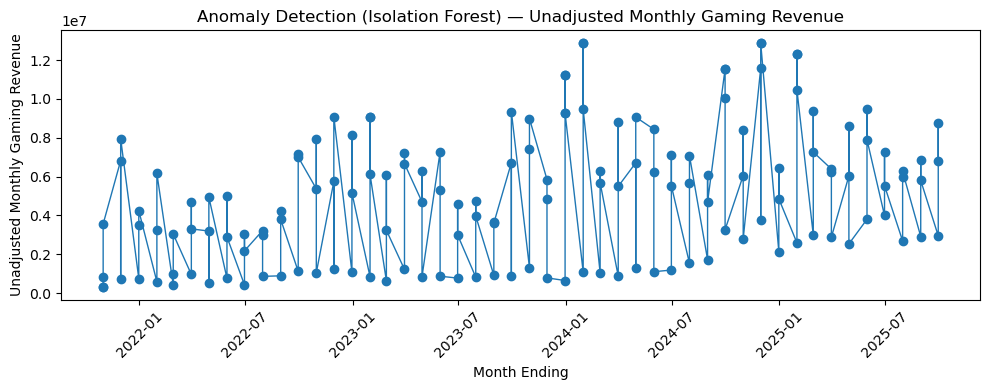

In [35]:

col = "Unadjusted Monthly Gaming Revenue"   

df_plot = df.sort_values("Month Ending").copy()

is_anom = df_plot["anomaly"] == -1

plt.figure(figsize=(10,4))
plt.plot(df_plot["Month Ending"], df_plot[col], marker="o", linewidth=1)

plt.scatter(df_plot.loc[is_anom, "Month Ending"],
            df_plot.loc[is_anom, col],
            marker="o")

plt.title(f"Anomaly Detection (Isolation Forest) — {col}")
plt.xlabel("Month Ending")
plt.ylabel(col)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:

numeric_features = [
    'Wagers',
    'Patron Winnings',
    'Cancelled Wagers',
    'Monthly Resettlements (3)',
    'Online Sports Wagering Win/(Loss)',
    'Federal Excise Tax (4)',
    'Unadjusted Monthly Gaming Revenue',
    'Promotional Coupons or Credits Wagered (5)',
    'Promotional Deduction (6)',
    'Payment (7)'
]

X_cluster = df[numeric_features]


In [37]:
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)


In [38]:
sil_scores = {}

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette score={score:.3f}")


k=2, silhouette score=0.466
k=3, silhouette score=0.374
k=4, silhouette score=0.369
k=5, silhouette score=0.360


In [39]:
# Final K-Means with optimal k=2
kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(X_cluster_scaled)

df["cluster"].value_counts()


cluster
1    78
0    66
Name: count, dtype: int64

In [40]:
cluster_summary = df.groupby("cluster")[numeric_features].mean()
cluster_summary


,Wagers,Patron Winnings,Cancelled Wagers,Monthly Resettlements (3),Online Sports Wagering Win/(Loss),Federal Excise Tax (4),Unadjusted Monthly Gaming Revenue,Promotional Coupons or Credits Wagered (5),Promotional Deduction (6),Payment (7)
cluster,,,,,,,,,,
0,2.371114e+07,2.159255e+07,104521.742424,27597.469697,1.986474e+06,57519.287879,1.928955e+06,7.237075e+05,3.477714e+05,217412.712121
1,7.011203e+07,6.254449e+07,245654.769231,13555.923077,7.308330e+06,169448.923077,7.138881e+06,1.987464e+06,1.215758e+06,814429.525641


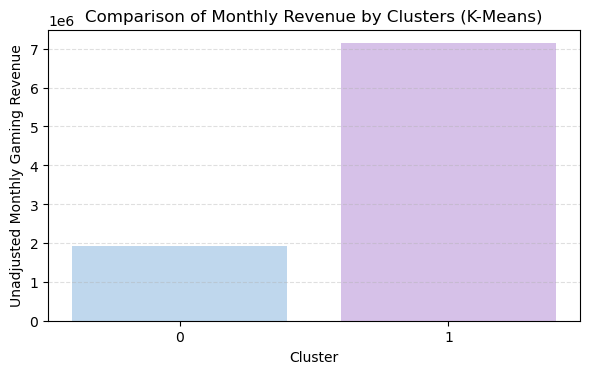

In [41]:

# חישוב ממוצע הכנסה חודשית לכל קלאסטר
cluster_means = df.groupby("cluster")["Unadjusted Monthly Gaming Revenue"].mean()

plt.figure(figsize=(6,4))
plt.bar(
    cluster_means.index.astype(str),
    cluster_means.values,
    color=["#BFD7ED", "#D6C1E8"]  
)

plt.title("Comparison of Monthly Revenue by Clusters (K-Means)", fontsize=12)
plt.xlabel("Cluster")
plt.ylabel("Unadjusted Monthly Gaming Revenue")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [42]:
pd.crosstab(df["cluster"], df["anomaly"])


anomaly,-1,1
cluster,,
0,1,65
1,7,71
